# Notebook on how to create two-dimensional labels that overlay wildfire polygons to the 3-Channel RGB imagery

## Delete warnings to prioritize the display of results

In [84]:
import warnings
warnings.filterwarnings('ignore')

## Import necessary libraries

In [87]:
import os
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box 
from shapely.geometry import shape
import rasterio.features

## Code to create the masks

In [90]:
# Define the paths to your Shapefile and the folder containing the after satellite images
shapefile_path = 'PolygonFiles/FirePolygons.shp'
image_folder = 'RGB/After'  # Replace with the actual folder path

# Read the Shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Reproject the shapefile to EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# Create a dictionary to store binary masks for each image
image_masks = {}

# Iterate through the rows in the attribute table
for index, row in gdf.iterrows():
    object_id = row['ORIGINALOI']
    image_name = f'RGB_AfterFire{object_id}.tif'  # Construct the image name based on the object ID

    # Check if the image exists in the folder
    image_path = os.path.join(image_folder, image_name)

    if os.path.exists(image_path):
        if image_name not in image_masks:
            with rasterio.open(image_path) as src:
                image_width = src.width
                image_height = src.height
                image_transform = src.transform
                image_bounds = box(src.bounds[0], src.bounds[1], src.bounds[2], src.bounds[3])  # Create a Shapely geometry from bounds
            image_masks[image_name] = np.zeros((image_height, image_width), dtype=np.uint8)

        geom = shape(row['geometry'])  # Extract the geometry column
       
        clipped_geom = geom.intersection(image_bounds.envelope)

        if not clipped_geom.is_empty:
            # Create a binary mask by rasterizing the clipped geometry
            clipped_mask = rasterio.features.geometry_mask([clipped_geom], out_shape=image_masks[image_name].shape, transform=image_transform, invert=True)

            # Combine the clipped mask with the mask for the specific image
            image_masks[image_name] = np.maximum(image_masks[image_name], clipped_mask)

# Overlay binary masks on the satellite images
for image_name, binary_mask in image_masks.items():
    image_path = os.path.join(image_folder, image_name)

    with rasterio.open(image_path) as src:
        image_data = src.read(1)  # Read the original image data

    # Overlay the binary mask on the image
    masked_image = np.where(binary_mask, image_data, 0)

    # Save the image with the mask overlay
    output_path = f'BinaryMasks/{image_name[:-4]}_with_mask.tif'  # Output image path with mask overlay
    with rasterio.open(output_path, 'w', driver='GTiff', width=image_data.shape[1], height=image_data.shape[0], count=1, dtype=image_data.dtype, crs=src.crs, transform=src.transform) as dst:
        dst.write(masked_image, 1)


## Code to define the areas where there is a polygon or a 1

In [85]:
# Specify the file name you're interested in
target_mask_file = 'RGB_AfterFire15_with_mask.tif'  # Replace with the actual file name

# Check if the file exists
if os.path.exists(target_mask_file):
    # Load the mask file
    with rasterio.open(target_mask_file) as mask_src:
        # Read the binary mask data
        binary_mask = mask_src.read(1)

        # Find indices where the binary mask has a value of 1
        ones_indices = np.where(binary_mask == 1)

        # Print the indices of ones
        print(f"Indices of ones in '{target_mask_file}':")
        print(ones_indices)
else:
    print(f"File '{target_mask_file}' not found.")


Indices of ones in 'RGB_AfterFire15_with_mask.tif':
(array([  30,  830,  830, 1122, 1661, 1662, 2875, 2952]), array([ 898,  650,  651,  559,  394,  394, 3093, 3069]))


## Code to test the dimensions of a specific mask or image

In [115]:
def get_image_dimensions(image_path):
    with rasterio.open(image_path) as dataset:
        width = dataset.width
        height = dataset.height
    return width, height

# Specify the path to the local image
image_path = 'BinaryMasksLocal/RGB_AfterFire10_with_mask.tif'  # Replace with the actual path to the desired image

# Get image dimensions
dimensions = get_image_dimensions(image_path)

# Print the dimensions
if dimensions:
    print(f"Width: {dimensions[0]}, Height: {dimensions[1]}")
else:
    print("Image dimensions not available.")


Width: 4492, Height: 3419


In [116]:
def get_image_dimensions(image_path):
    with rasterio.open(image_path) as dataset:
        width = dataset.width
        height = dataset.height
    return width, height

# Specify the path to the local image
image_path = 'RGB/After/RGB_AfterFire10.tif'  # Replace with the actual path to the desired image

# Get image dimensions
dimensions = get_image_dimensions(image_path)

# Print the dimensions
if dimensions:
    print(f"Width: {dimensions[0]}, Height: {dimensions[1]}")
else:
    print("Image dimensions not available.")


Width: 4492, Height: 3419


## Code to save all the displayed masks in the BinaryMasksDisplay folder

In [93]:
from IPython.display import Image, display
from PIL import Image as PILImage, ImageEnhance
import tifffile as tiff
import numpy as np
import os

# Specify the paths to your input and output folders
input_folder = "BinaryMasks"
output_folder = "BinaryMasksDisplay"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        # Construct the full paths for input and output
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_display.png")

        # Open and convert the TIFF image to grayscale
        with tiff.TiffFile(input_path) as tif:
            tiff_image = tif.pages[0].asarray()
            tiff_image = ((tiff_image - tiff_image.min()) / (tiff_image.max() - tiff_image.min()) * 255).astype(np.uint8)
            pil_image = PILImage.fromarray(tiff_image)

        # Increase the brightness
        enhancer = ImageEnhance.Brightness(pil_image)
        brightened_image = enhancer.enhance(2)  # You can adjust the factor as needed

        # Resize the image to fit the screen
        screen_width = 800  # You can adjust this width based on your preference
        aspect_ratio = brightened_image.width / brightened_image.height
        resized_image = brightened_image.resize((screen_width, int(screen_width / aspect_ratio)))

        # Save the resized image as a PNG file
        resized_image.save(output_path, "PNG")


## Code to display a specific image in the console for testing purposes

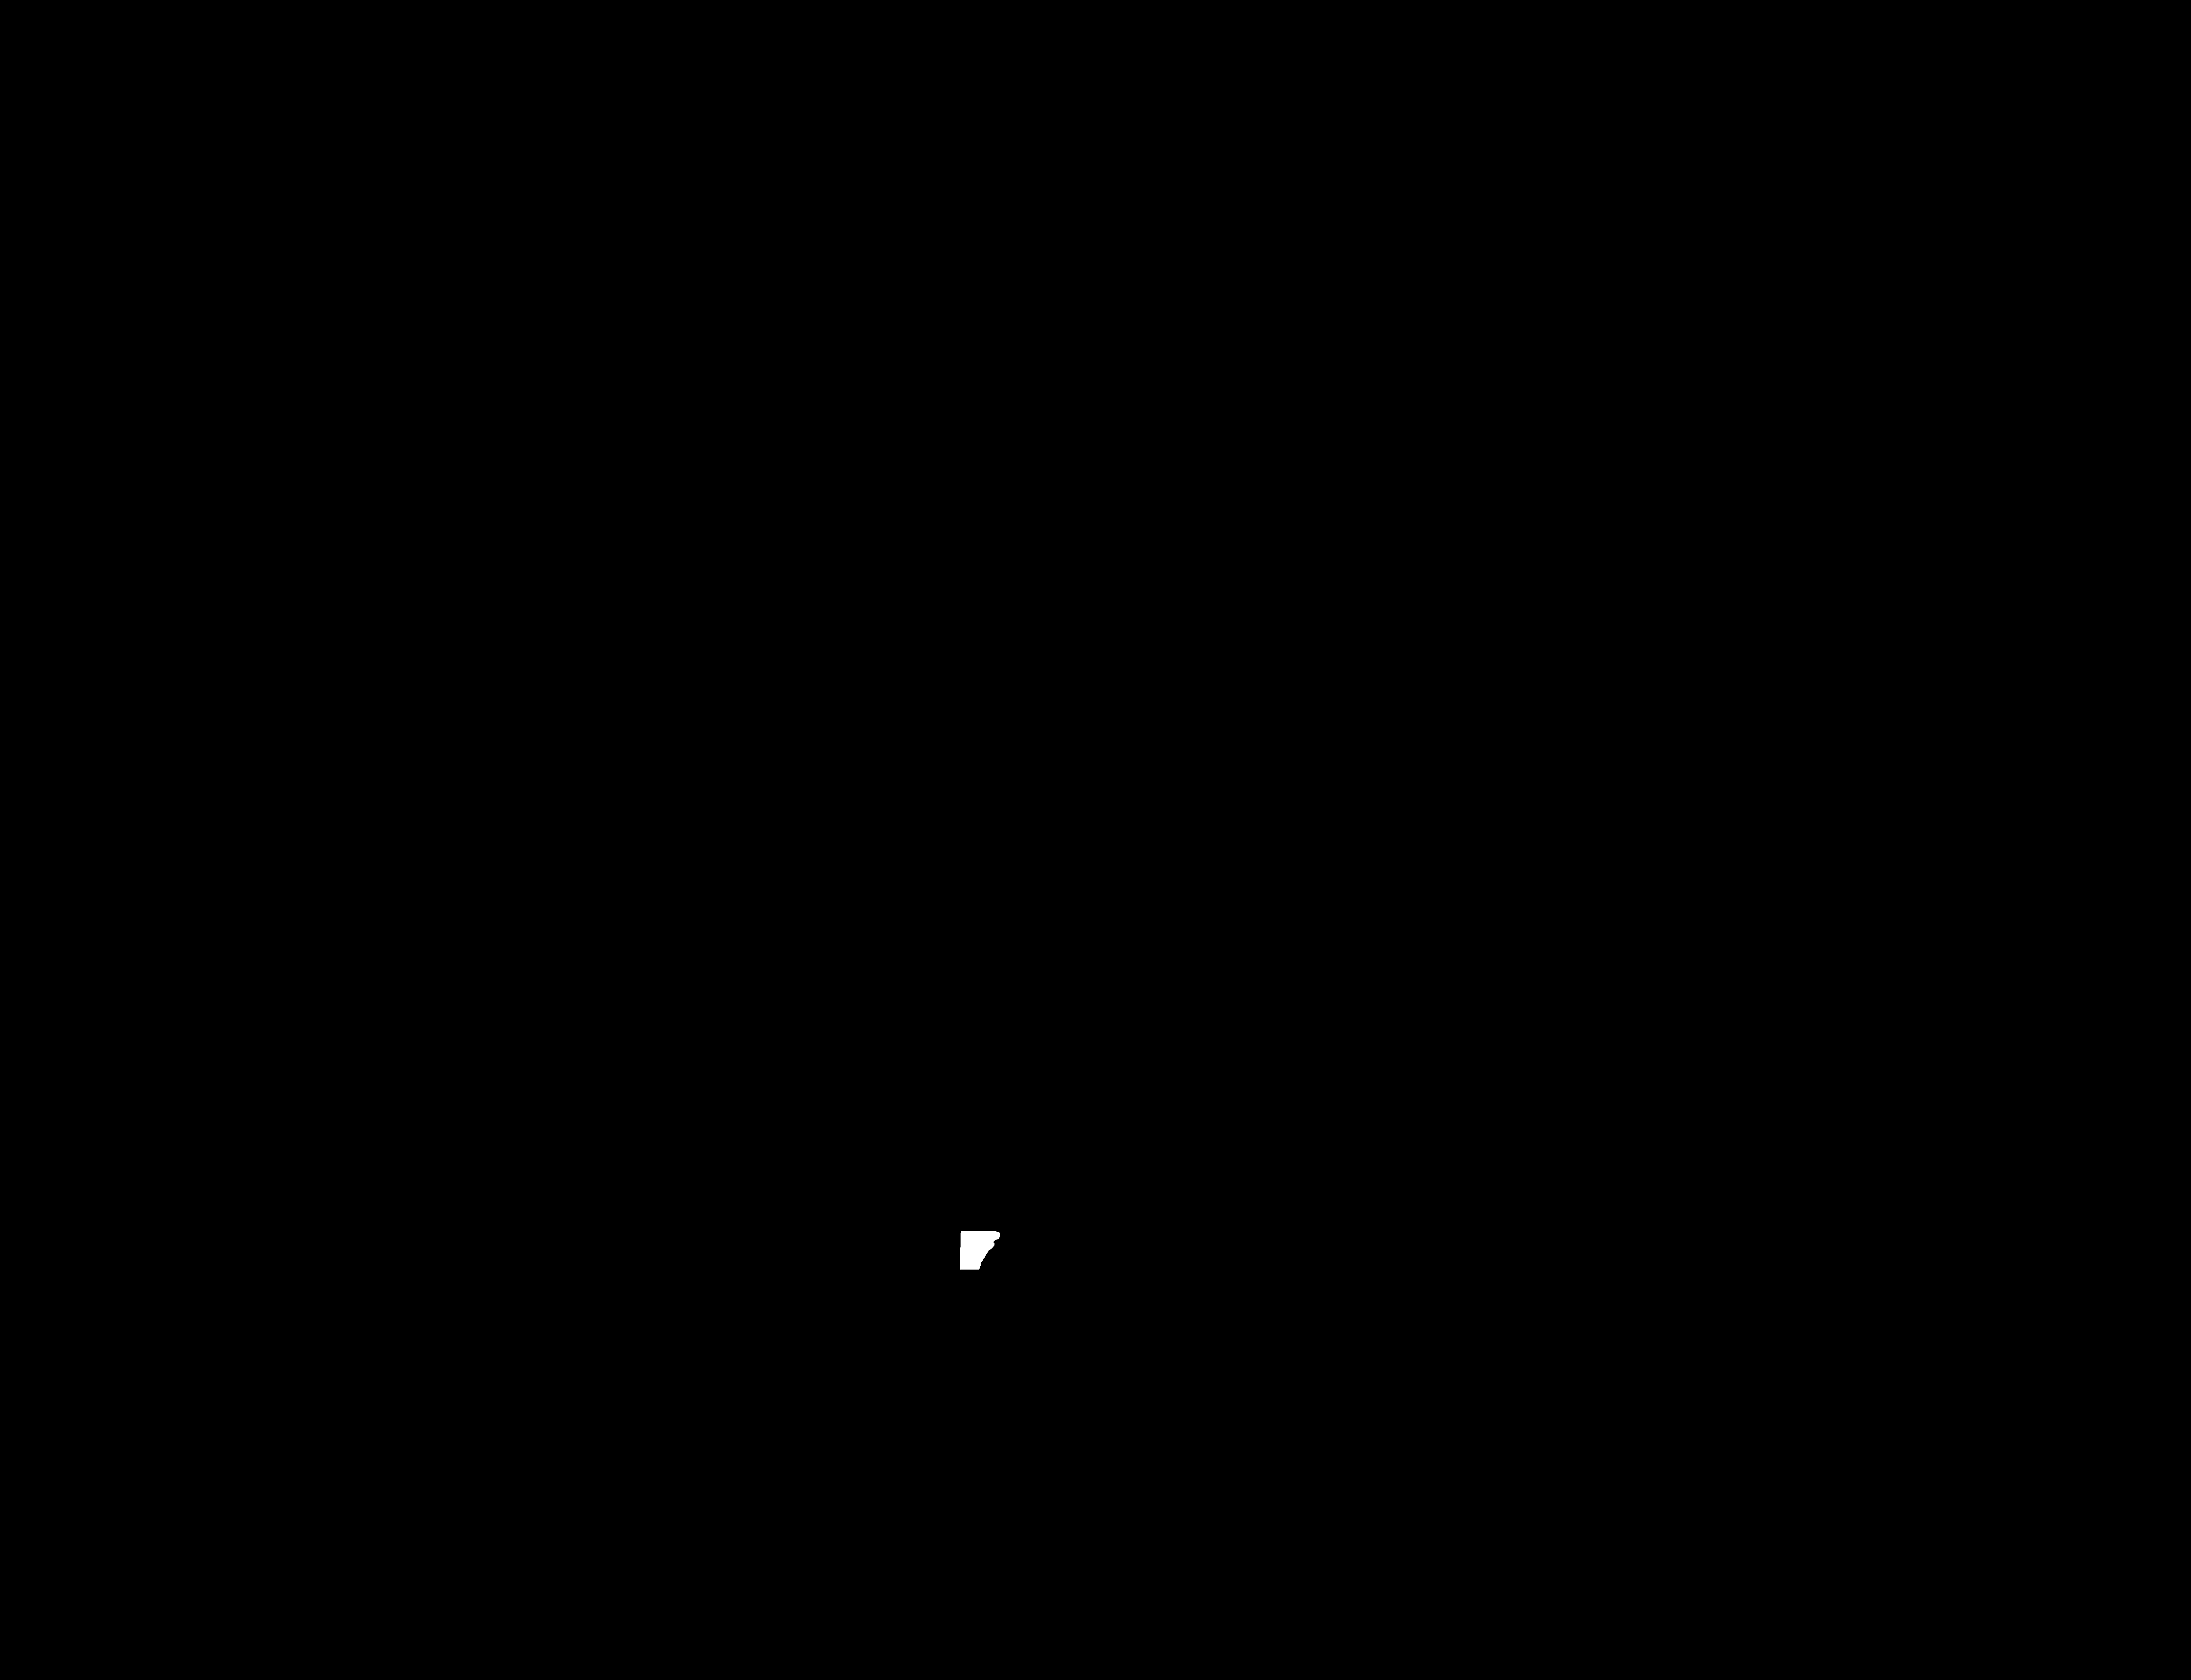

In [100]:
from IPython.display import Image, display
from PIL import Image as PILImage, ImageEnhance  # Import ImageEnhance
import tifffile as tiff
import numpy as np
import os
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your TIFF image
image_path1 = "BinaryMasksLocal/RGB_AfterFire1_with_mask.tif"

# Open and convert the TIFF image to grayscale
with tiff.TiffFile(image_path1) as tif:
    # Extract the first page (you can adjust this based on your needs)
    tiff_image = tif.pages[0].asarray()

    # Normalize the pixel values to the 0-255 range
    tiff_image = ((tiff_image - tiff_image.min()) / (tiff_image.max() - tiff_image.min()) * 255).astype(np.uint8)

    # Create a PIL image from the numpy array
    pil_image = PILImage.fromarray(tiff_image)
    
# Increase the brightness
enhancer = ImageEnhance.Brightness(pil_image)
brightened_image = enhancer.enhance(2)  # You can adjust the factor as needed

# Save the brightened image as a temporary PNG file
png_image_path = "temp_image.png"
brightened_image.save(png_image_path, "PNG")

# Display the brightened PNG image
display(Image(filename=png_image_path))

# Optionally, you can delete the temporary PNG file
os.remove(png_image_path)
